# Jovian Analysis - Final Version

Complete notebook for Jovian calldata footprint gas scalar analysis with all fixes.

## Features
- ✅ Multi-chain support (7 chains)
- ✅ Date range analysis with per-date breakdown
- ✅ Dynamic gas limits from per-chain CSV
- ✅ Compression ratio analysis
- ✅ Both sampling methods: top percentile and random
- ✅ Enhanced visualizations with vertical lines and zones
- ✅ Comprehensive summary visualization
- ✅ Optimal scalar recommendations

In [3]:
%load_ext autoreload
%autoreload 2

## Step 1: Setup and Configuration

In [12]:
# Core imports
import sys
from pathlib import Path
import polars as pl
from datetime import datetime, timedelta
from collections import Counter
import matplotlib.pyplot as plt
import time
import numpy as np

# Add parent directory to path
sys.path.append(str(Path.cwd().parent))

# Import Jovian modules
from jovian_src.chain_config import (
    get_chain_display_name,
    get_chain_color,
    DEFAULT_CALLDATA_FOOTPRINT_GAS_SCALARS
)
from jovian_src.clickhouse_fetcher import (
    load_gas_limits,
    fetch_top_percentile_blocks,
    fetch_random_sample_blocks
)
from jovian_src.analysis_functions import (
    perform_jovian_analysis,
    generate_jovian_recommendation
)
from jovian_src.visualization_jovian import (
    generate_all_visualizations
)

print("✅ Modules loaded successfully")

✅ Modules loaded successfully


In [5]:
# Analysis parameters
CHAIN = "base"  # Options: base, optimism, mode, zora, world, ink, soneium

# Sampling method
SAMPLING_METHOD = "top_percentile"  # "top_percentile" or "random"
PERCENTILE = 99.0    # For top percentile (99 = top 1%)
NUM_BLOCKS = 100     # For random sampling - number of blocks per day
RANDOM_SEED = 42     # For reproducible random sampling

DATA_PATH = "../gas_limits"
FILE_PATH = f"{CHAIN}_gas_limits.csv"
# Date range configuration
START_DATE = "2025-01-01"
END_DATE = "2025-02-01"  # Inclusive

# Jovian parameters
CALLDATA_FOOTPRINT_GAS_SCALARS = DEFAULT_CALLDATA_FOOTPRINT_GAS_SCALARS  # [160, 400, 600, 800]
BLOCK_LIMIT = None   # None = all blocks for selected method

# Output directory
OUTPUT_DIR = Path(f"../results/{CHAIN}/visualizations_{SAMPLING_METHOD.lower()}_{START_DATE}_{END_DATE}")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Generate date list
start = datetime.strptime(START_DATE, "%Y-%m-%d")
end = datetime.strptime(END_DATE, "%Y-%m-%d")
DATES_TO_ANALYZE = []
current = start
while current <= end:
    DATES_TO_ANALYZE.append(current.strftime("%Y-%m-%d"))
    current += timedelta(days=1)

print(f"🚀 JOVIAN CONFIGURATION")
print("=" * 60)
print(f"Chain: {get_chain_display_name(CHAIN)}")
print(f"Sampling: {SAMPLING_METHOD}")
if SAMPLING_METHOD == "top_percentile":
    print(f"   Percentile: Top {100 - PERCENTILE:.0f}%")
else:
    print(f"   Number of blocks: {NUM_BLOCKS}")
    print(f"   Random seed: {RANDOM_SEED}")
print(f"Date range: {START_DATE} to {END_DATE}")
print(f"Dates to analyze: {len(DATES_TO_ANALYZE)} day(s)")
print(f"Calldata footprint gas scalars: {CALLDATA_FOOTPRINT_GAS_SCALARS}")

# Show dates if range is small
if len(DATES_TO_ANALYZE) <= 7:
    print(f"\n📅 Dates: {', '.join(DATES_TO_ANALYZE)}")

🚀 JOVIAN CONFIGURATION
Chain: Base
Sampling: top_percentile
   Percentile: Top 1%
Date range: 2025-01-01 to 2025-02-01
Dates to analyze: 32 day(s)
Calldata footprint gas scalars: [160, 400, 600, 800]


## Step 2: Load Gas Limits

In [6]:

# Load historical gas limits for the selected chain
gas_limits_df = load_gas_limits(csv_path=f"{DATA_PATH}/{FILE_PATH}")

def get_gas_limit_for_date(date_str: str, gas_limits_df: pl.DataFrame, chain: str = "base") -> int:
    """Get gas limit for date_str; fall back to most recent prior date, else 240M."""
    # exact match
    result = gas_limits_df.filter(pl.col("date_formatted") == date_str)
    if result.height:
        return int(result["gas_limit"][0])

    # previous (<=) by formatted date string (YYYY-MM-DD ordering is lexicographic-safe)
    prev = (
        gas_limits_df
        .filter(pl.col("date_formatted") <= date_str)
        .sort("date_formatted")
        .tail(1)
    )
    if prev.height:
        return int(prev["gas_limit"][0])

    # final fallback if the requested date is before earliest entry
    return None

# Get gas limits for all dates
date_gas_limits = {}
for date in DATES_TO_ANALYZE:
    gas_limit = get_gas_limit_for_date(date, gas_limits_df, chain=CHAIN)
    date_gas_limits[date] = gas_limit
    if len(DATES_TO_ANALYZE) <= 7:
        print(f"📊 Gas limit for {date}: {gas_limit:,}")

# Determine gas limit for combined analysis
unique_limits = set(date_gas_limits.values())
if len(unique_limits) > 1:
    print(f"\n⚠️  Multiple gas limits detected: {', '.join(f'{gl:,}' for gl in sorted(unique_limits))}")
    # Use the most common gas limit for combined analysis
    limit_counts = Counter(date_gas_limits.values())
    ANALYSIS_GAS_LIMIT = limit_counts.most_common(1)[0][0]
    print(f"📊 Using most common for combined analysis: {ANALYSIS_GAS_LIMIT:,}")
else:
    ANALYSIS_GAS_LIMIT = list(unique_limits)[0]
    print(f"\n📊 Consistent gas limit across all dates: {ANALYSIS_GAS_LIMIT:,}")


⚠️  Multiple gas limits detected: 240,000,000, 242,336,329, 252,000,000, 255,359,144, 264,000,000, 271,196,538, 288,000,000
📊 Using most common for combined analysis: 240,000,000


## Step 3: Fetch Data

In [7]:
# Compare parallel vs sequential fetching
all_dataframes = []
fetch_summary = []
per_date_dataframes = {}  # Store individual dataframes

method_display = "top 1%" if SAMPLING_METHOD == "top_percentile" else f"{NUM_BLOCKS} random blocks"

# SEQUENTIAL FETCHING (fallback for single date or when disabled)
print(f"📥 SEQUENTIAL FETCHING: {method_display} blocks for {len(DATES_TO_ANALYZE)} date(s)...")
print("=" * 60)

start_time = time.time()

for date in DATES_TO_ANALYZE:
    gas_limit = date_gas_limits[date]
    if len(DATES_TO_ANALYZE) <= 7:
        print(f"\n📅 Fetching {date} (gas limit: {gas_limit:,})")
    
    if SAMPLING_METHOD == "top_percentile":
        df, actual_gas_limit = fetch_top_percentile_blocks(
            chain=CHAIN,
            date=date,
            percentile=PERCENTILE,
            limit=BLOCK_LIMIT,
            gas_limit=gas_limit
        )
    else:
        df, actual_gas_limit = fetch_random_sample_blocks(
            chain=CHAIN,
            date=date,
            num_blocks=NUM_BLOCKS,
            gas_limit=gas_limit,
            seed=RANDOM_SEED
        )
    
    if not df.is_empty():
        all_dataframes.append(df)
        per_date_dataframes[date] = df  # Store individual dataframe
        blocks = df['block_number'].n_unique()
        txs = len(df)
        fetch_summary.append({
            'date': date,
            'blocks': blocks,
            'transactions': txs,
            'gas_limit': actual_gas_limit,
            'df': df  # Store individual dataframe
        })
        if len(DATES_TO_ANALYZE) <= 7:
            print(f"   ✅ Fetched {blocks} blocks, {txs:,} transactions")
    else:
        print(f"   ⚠️  No data for {date}")

sequential_time = time.time() - start_time
print(f"\n📊 Sequential Performance:")
print(f"   Total time: {sequential_time:.1f}s")
print(f"   Average per date: {sequential_time/len(DATES_TO_ANALYZE):.1f}s")

combined_df = pl.concat(all_dataframes)
print(f"\n✅ Data fetching complete!")
print(f"   Total dates with data: {len(fetch_summary)}")
print(f"   Total blocks: {combined_df['block_number'].n_unique():,}")
print(f"   Total transactions: {len(combined_df):,}")
print(f"   Average calldata: {combined_df['calldata_size'].mean():.0f} bytes")
print(f"   Max calldata: {combined_df['calldata_size'].max():.0f} bytes")


📥 SEQUENTIAL FETCHING: top 1% blocks for 32 date(s)...
2025-08-26 00:15:04 [info     ] loaded vault from .env file    filename=vault.py lineno=32 process=17007
2025-08-26 00:15:04 [debug    ] loaded vault: 28 items         filename=vault.py lineno=79 process=17007
2025-08-26 00:15:04 [debug    ] connecting to OPLABS Clickhouse client... filename=client.py lineno=56 process=17007
2025-08-26 00:15:04 [debug    ] initialized OPLABS Clickhouse client. filename=client.py lineno=61 process=17007

📊 Sequential Performance:
   Total time: 169.4s
   Average per date: 5.3s

✅ Data fetching complete!
   Total dates with data: 32
   Total blocks: 13,811
   Total transactions: 7,821,937
   Average calldata: 350 bytes
   Max calldata: 130732 bytes


## Step 4: Perform Combined Jovian Analysis

In [8]:
# Analyze combined data with multiple calldata footprint gas scalars
if not combined_df.is_empty():
    print(f"📊 ANALYZING COMBINED DATA")
    print("=" * 60)
    print(f"Chain: {get_chain_display_name(CHAIN)}")
    print(f"Dates analyzed: {len(fetch_summary)}")
    print(f"Gas limit: {ANALYSIS_GAS_LIMIT:,}")
    print(f"Sampling method: {SAMPLING_METHOD}")
    
    analysis_results = perform_jovian_analysis(
        df=combined_df,
        gas_limit=ANALYSIS_GAS_LIMIT,
        calldata_footprint_gas_scalars=CALLDATA_FOOTPRINT_GAS_SCALARS,
        chain=CHAIN,
        sampling_method=SAMPLING_METHOD,
        start_date=START_DATE,
        end_date=END_DATE,
        show_progress=True
    )
    
    print("\n✅ Jovian analysis complete!")
else:
    print("❌ No data to analyze")
    analysis_results = {}

📊 ANALYZING COMBINED DATA
Chain: Base
Dates analyzed: 32
Gas limit: 240,000,000
Sampling method: top_percentile

🚀 JOVIAN ANALYSIS SUMMARY
Chain: Base
Sampling Method: top_percentile
Date Range: 2025-01-01 → 2025-02-01
Gas Limit: 240,000,000
Calldata Footprint Gas Scalars: [160, 400, 600, 800]

📊 Analyzing Base with calldata footprint gas scalar: 160
   Effective limit: 1,500,000 bytes
   Sampling method: top_percentile
🚀 Analyzing 13811 blocks with 10 workers...


Processing blocks: 100%|██████████| 13811/13811 [01:01<00:00, 225.49it/s]


   ✅ Blocks exceeding: 0/13811 (0.0%)
   📈 Avg utilization: 3.78%
   🗜️ Avg compression ratio: 2.58x

📊 Analyzing Base with calldata footprint gas scalar: 400
   Effective limit: 600,000 bytes
   Sampling method: top_percentile
🚀 Analyzing 13811 blocks with 10 workers...


Processing blocks: 100%|██████████| 13811/13811 [01:01<00:00, 224.62it/s]


   ✅ Blocks exceeding: 0/13811 (0.0%)
   📈 Avg utilization: 9.44%
   🗜️ Avg compression ratio: 2.58x

📊 Analyzing Base with calldata footprint gas scalar: 600
   Effective limit: 400,000 bytes
   Sampling method: top_percentile
🚀 Analyzing 13811 blocks with 10 workers...


Processing blocks: 100%|██████████| 13811/13811 [01:05<00:00, 210.09it/s]


   ✅ Blocks exceeding: 0/13811 (0.0%)
   📈 Avg utilization: 14.16%
   🗜️ Avg compression ratio: 2.58x

📊 Analyzing Base with calldata footprint gas scalar: 800
   Effective limit: 300,000 bytes
   Sampling method: top_percentile
🚀 Analyzing 13811 blocks with 10 workers...


Processing blocks: 100%|██████████| 13811/13811 [01:01<00:00, 225.43it/s]


   ✅ Blocks exceeding: 0/13811 (0.0%)
   📈 Avg utilization: 18.88%
   🗜️ Avg compression ratio: 2.58x

✅ Jovian analysis complete!


## Step 5: View Results with Compression Metrics

In [9]:
# Display analysis results including compression metrics
if analysis_results:
    print(f"🚀 JOVIAN ANALYSIS RESULTS - {get_chain_display_name(CHAIN)}")
    print("=" * 60)
    
    for scalar in sorted(analysis_results.keys()):
        result = analysis_results[scalar]
        print(f"\n🔹 Calldata Footprint Gas Scalar: {scalar}")
        print(f"   Effective limit: {result.gas_limit // scalar:,} bytes")
        print(f"   Blocks exceeding: {result.blocks_exceeding}/{result.total_blocks} ({result.percentage_exceeding:.2f}%)")
        print(f"   Avg utilization: {result.avg_utilization:.2%}")
        print(f"   Max utilization: {result.max_utilization:.2%}")

        # ⛽ DA footprint vs *block gas used* (as % of gas used)
        if getattr(result, "blocks_with_gas_used", 0) > 0:
            mean_pct   = result.avg_util_vs_gas_used * 100
            median_pct = result.median_util_vs_gas_used * 100
            p95_pct    = result.p95_util_vs_gas_used * 100

            over_cnt_measured = int(round(result.share_over_1_vs_used * result.blocks_with_gas_used))
            over_pct_measured = result.share_over_1_vs_used * 100

            # Optional: express as share of ALL blocks too (matches the “Blocks exceeding” style)
            over_pct_all = (over_cnt_measured / result.total_blocks * 100) if result.total_blocks else 0

            print(f"\n   ⛽ DA footprint vs Block Gas Used:")
            print(f"      mean:   {mean_pct:.1f}%")
            print(f"      median: {median_pct:.1f}%   |   p95: {p95_pct:.1f}%")
            print(f"      Blocks over gas-used budget (>100%): "
                f"{over_cnt_measured}/{result.blocks_with_gas_used} ({over_pct_measured:.1f}%) ")
        else:
            print("\n   ⛽ DA footprint vs Block Gas Used: n/a (no blocks had block_gas_used)")
        
        # Show compression metrics
        if result.compression_metrics:
            print(f"\n   📊 Compression Metrics:")
            print(f"      Avg compression ratio: {result.compression_metrics.get('avg_compression_ratio', 0):.2f}x")
            print(f"      Median compression: {result.compression_metrics.get('median_compression_ratio', 0):.2f}x")
            print(f"      DA efficiency: {result.compression_metrics.get('avg_da_efficiency', 0):.1%}")
        
        if result.blocks_exceeding > 0:
            print(f"   Avg excess: {result.avg_excess_percentage:.1f}%")
            print(f"   Max excess: {result.max_excess_percentage:.1f}%")




🚀 JOVIAN ANALYSIS RESULTS - Base

🔹 Calldata Footprint Gas Scalar: 160
   Effective limit: 1,500,000 bytes
   Blocks exceeding: 0/13811 (0.00%)
   Avg utilization: 3.78%
   Max utilization: 8.47%

   ⛽ DA footprint vs Block Gas Used:
      mean:   16.8%
      median: 12.5%   |   p95: 36.7%
      Blocks over gas-used budget (>100%): 0/13811 (0.0%) 

   📊 Compression Metrics:
      Avg compression ratio: 2.58x
      Median compression: 2.49x
      DA efficiency: 29.2%

🔹 Calldata Footprint Gas Scalar: 400
   Effective limit: 600,000 bytes
   Blocks exceeding: 0/13811 (0.00%)
   Avg utilization: 9.44%
   Max utilization: 21.17%

   ⛽ DA footprint vs Block Gas Used:
      mean:   41.9%
      median: 31.1%   |   p95: 91.7%
      Blocks over gas-used budget (>100%): 260/13811 (1.9%) 

   📊 Compression Metrics:
      Avg compression ratio: 2.58x
      Median compression: 2.49x
      DA efficiency: 29.2%

🔹 Calldata Footprint Gas Scalar: 600
   Effective limit: 400,000 bytes
   Blocks exceedin

## Step 6: Generate Jovian Recommendation

In [14]:
print(f"\n🎯 RECOMMENDATION - {get_chain_display_name(CHAIN)}")
print("=" * 60)

rec = generate_jovian_recommendation(
    results=analysis_results,            
    chain=CHAIN,
    start_date=START_DATE,
    end_date=END_DATE,
    target_excess_rate=0.01
)

for opt in rec["all_options"]:
    s = opt["calldata_footprint_gas_scalar"]
    tick = "✅" if opt["blocks_exceeding_pct"] <= 1 else ("⚠️" if opt["blocks_exceeding_pct"] <= 5 else "❌")

    # Avg compression from recommendation dict
    avg_comp = opt.get("avg_compression_ratio", 0.0)

    # Median compression from analysis_results (no lib changes needed)
    median_comp = 0.0
    if s in analysis_results and analysis_results[s].compression_metrics:
        median_comp = analysis_results[s].compression_metrics.get("median_compression_ratio", 0.0)

    # DA footprint > gas used share (only if measured)
    measured = opt.get("measured_blocks_gas_used", 0) or 0
    over_pct = opt.get("over_gas_used_pct", None)
    over_str = (
        f" | DA footprint > block gas used: {over_pct:.2f}% of {measured:,} blocks"
        if (over_pct is not None and measured > 0) else ""
    )

    print(
        f"{tick} Scalar {s}: {opt['blocks_exceeding_pct']:.2f}% exceeds gas limit, {opt['assessment']} | "
        f"avg comp {avg_comp:.2f}x (median {median_comp:.2f}x){over_str}"
    )



🎯 RECOMMENDATION - Base
✅ Scalar 160: 0.00% exceeds gas limit, Very Conservative | avg comp 2.58x (median 2.49x) | DA footprint > block gas used: 0.00% of 13,811 blocks
✅ Scalar 400: 0.00% exceeds gas limit, Very Conservative | avg comp 2.58x (median 2.49x) | DA footprint > block gas used: 1.88% of 13,811 blocks
✅ Scalar 600: 0.00% exceeds gas limit, Very Conservative | avg comp 2.58x (median 2.49x) | DA footprint > block gas used: 25.27% of 13,811 blocks
✅ Scalar 800: 0.00% exceeds gas limit, Very Conservative | avg comp 2.58x (median 2.49x) | DA footprint > block gas used: 36.57% of 13,811 blocks


## Step 7: Generate Enhanced Visualizations

📊 Generating enhanced visualizations for Base...
📊 Generating enhanced size estimates histogram...
✅ Saved size estimates histogram to ../results/base/visualizations_top_percentile_2025-01-01_2025-02-01/1_size_estimates_histogram.png
📊 Generating compression ratio histogram...
✅ Saved enhanced compression histogram to ../results/base/visualizations_top_percentile_2025-01-01_2025-02-01/2_compression_histogram.png
📊 Generating exceeding limits analysis...
✅ Saved exceeding limits analysis to ../results/base/visualizations_top_percentile_2025-01-01_2025-02-01/3_exceeding_limits_analysis.png
📊 Generating excess distribution...
✅ No blocks exceed limits for any scalar
📊 Generating over-utilization analysis...
✅ Saved over-utilization analysis to ../results/base/visualizations_top_percentile_2025-01-01_2025-02-01/5_over_utilization_analysis.png
📊 Generating scalar comparison...


/Users/chuxinhuang/work/op-analytics/notebooks/adhoc/jovian_top_percentile_analysis/jovian_src/visualization_jovian.py:742: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')


✅ Saved scalar comparison to ../results/base/visualizations_top_percentile_2025-01-01_2025-02-01/6_scalar_comparison.png
📊 Generating comprehensive summary...


/Users/chuxinhuang/work/op-analytics/notebooks/adhoc/jovian_top_percentile_analysis/jovian_src/visualization_jovian.py:1093: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/Users/chuxinhuang/work/op-analytics/notebooks/adhoc/jovian_top_percentile_analysis/jovian_src/visualization_jovian.py:1097: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Arial.
  plt.savefig(save_path, dpi=150, bbox_inches='tight')


✅ Saved comprehensive summary to ../results/base/visualizations_top_percentile_2025-01-01_2025-02-01/7_comprehensive_summary.png
✅ Generated 7 visualizations

✅ Generated 7 visualizations:
   1. Size estimates histogram (with vertical lines & zones)
   2. Compression ratio histogram (with percentiles & zones)
   3. Blocks exceeding limits analysis
   4. Excess distribution
   5. Over-utilization percentages
   6. Scalar comparison
   7. Comprehensive summary (NEW)

📁 Saved to: ../results/base/visualizations_top_percentile_2025-01-01_2025-02-01


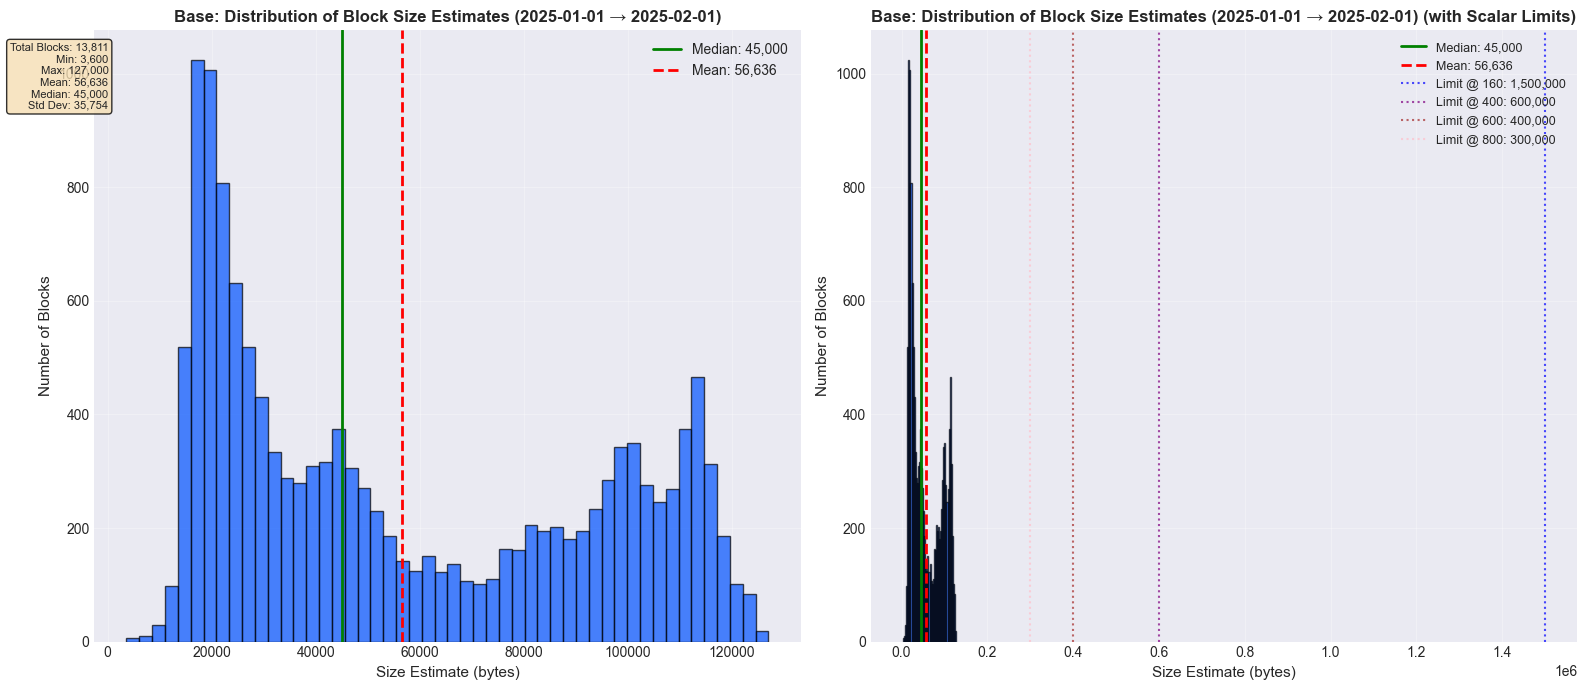

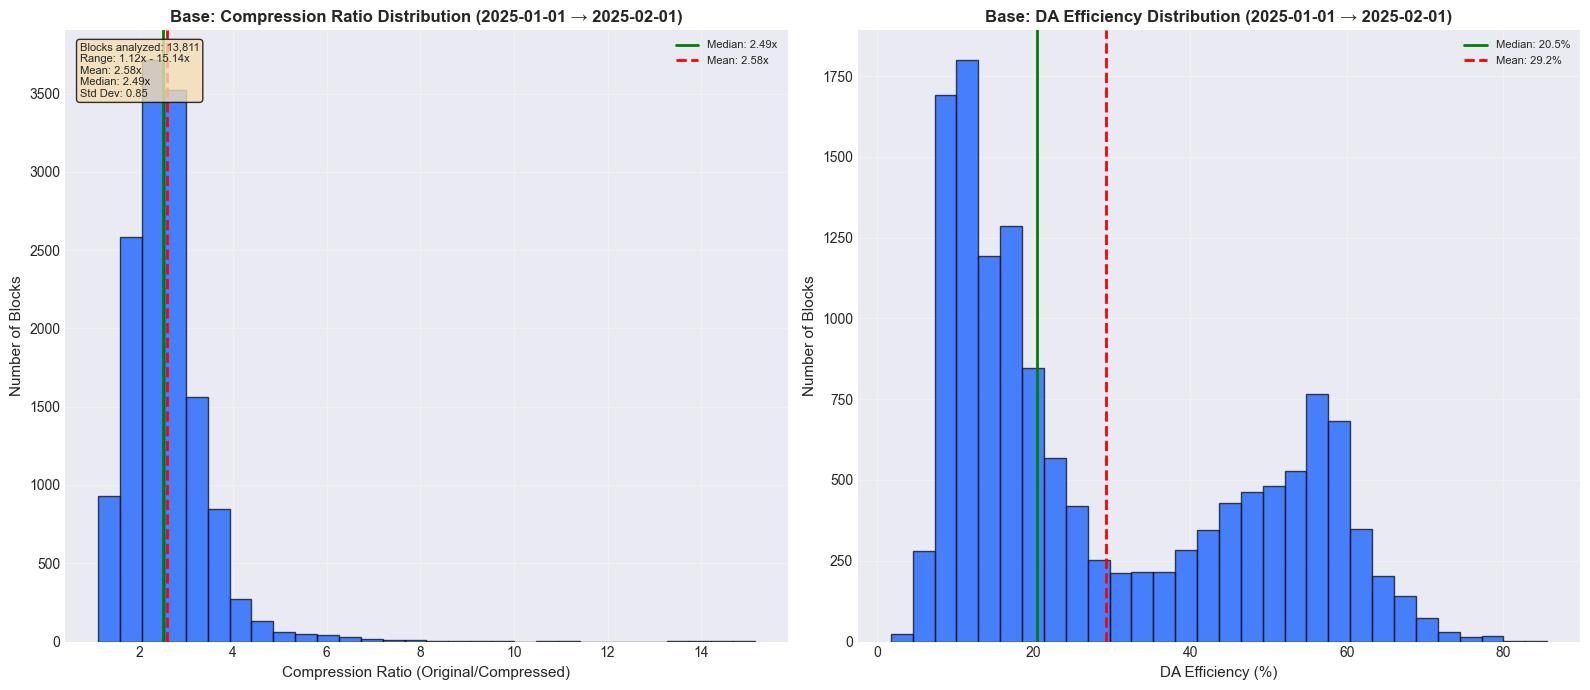

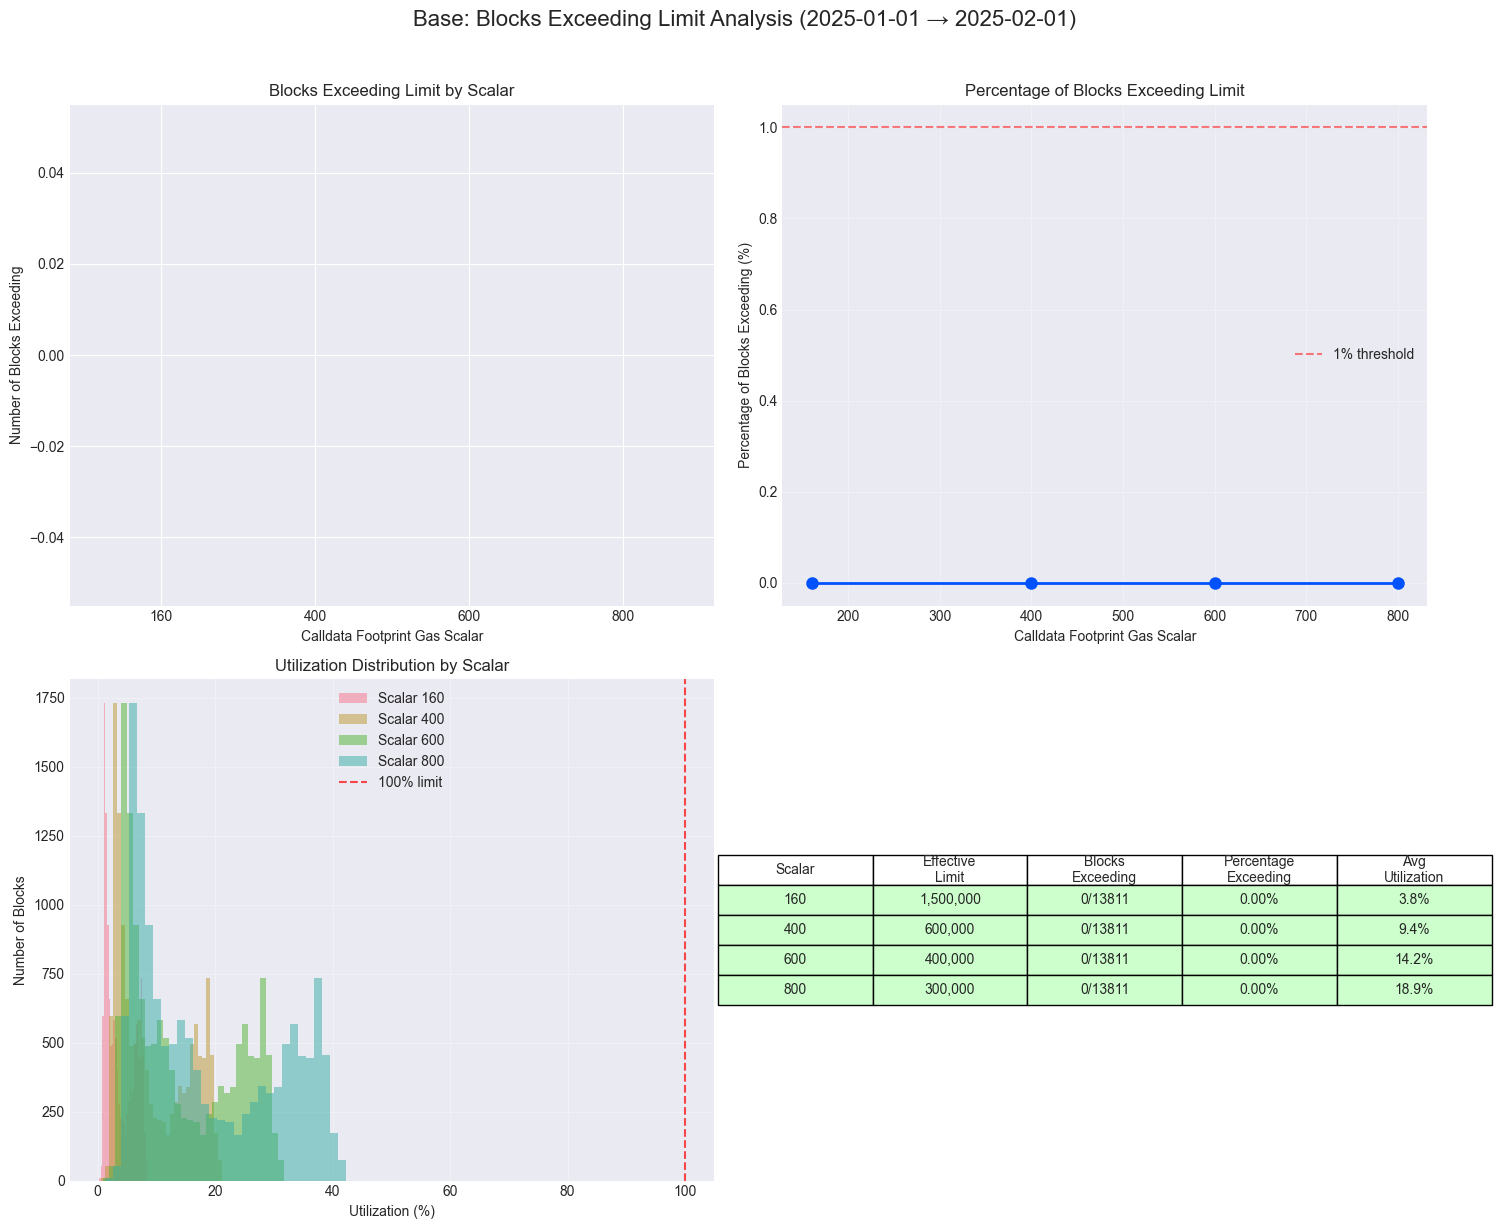

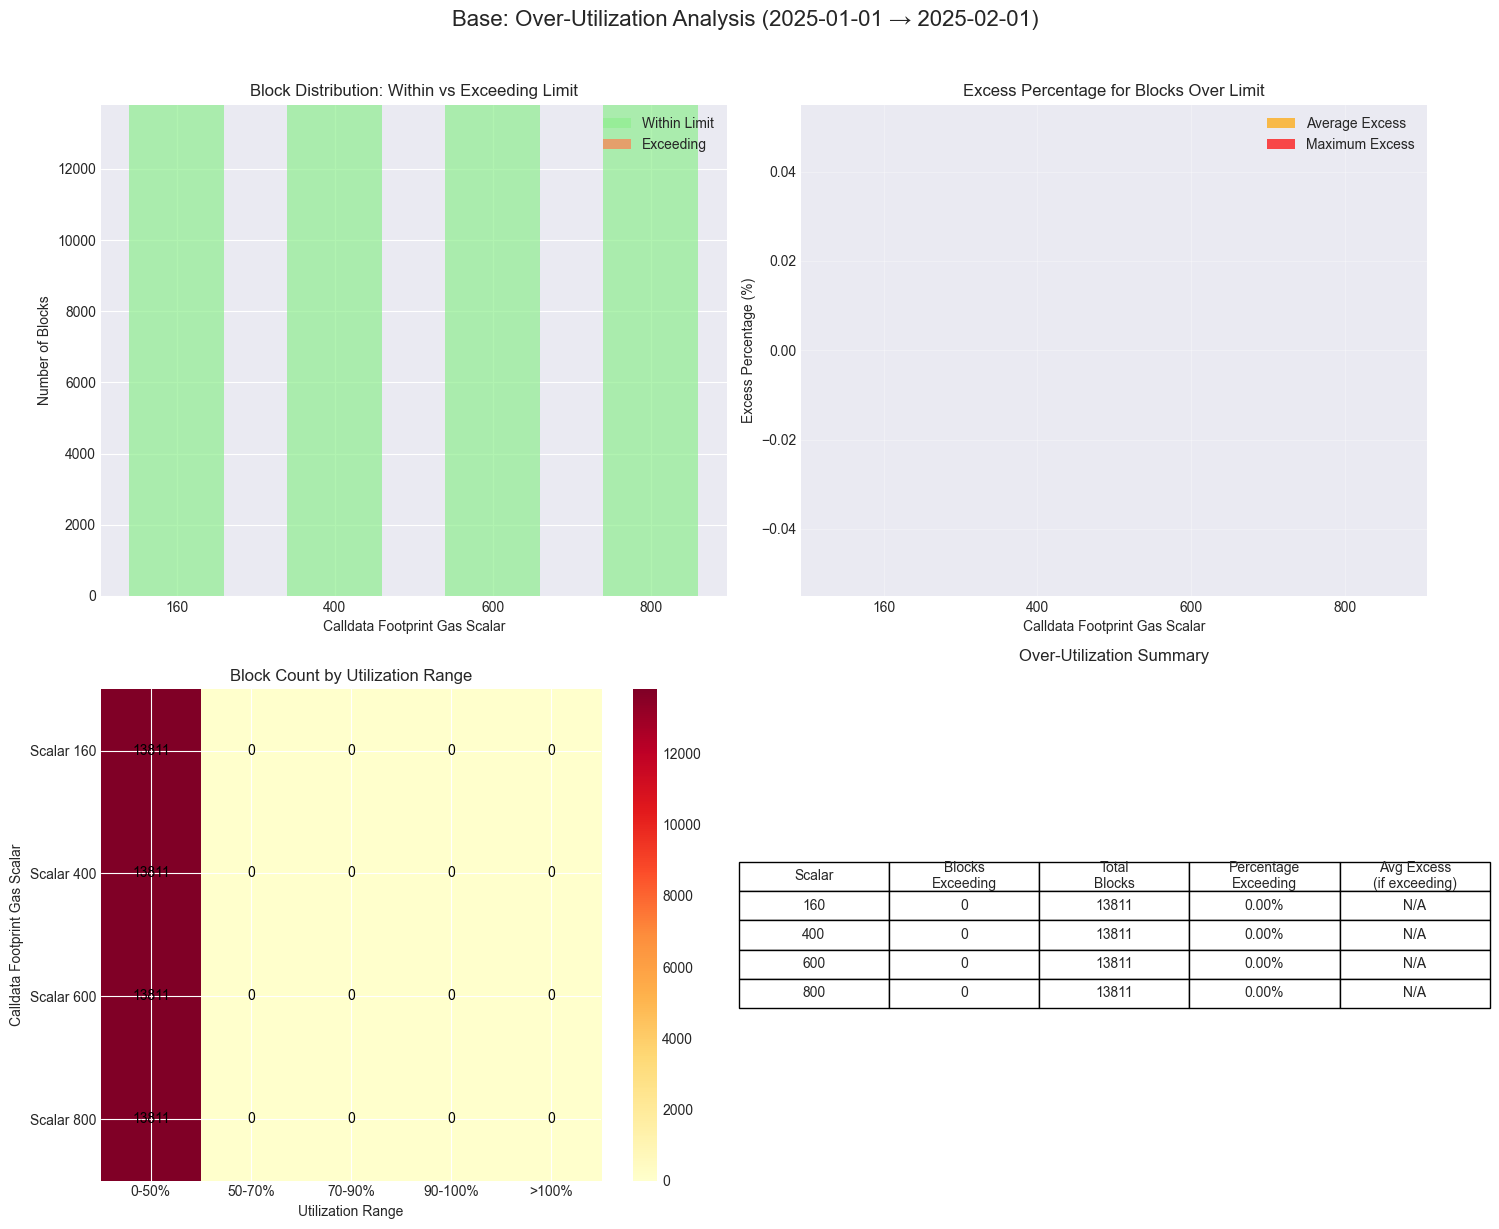

/Users/chuxinhuang/work/op-analytics/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


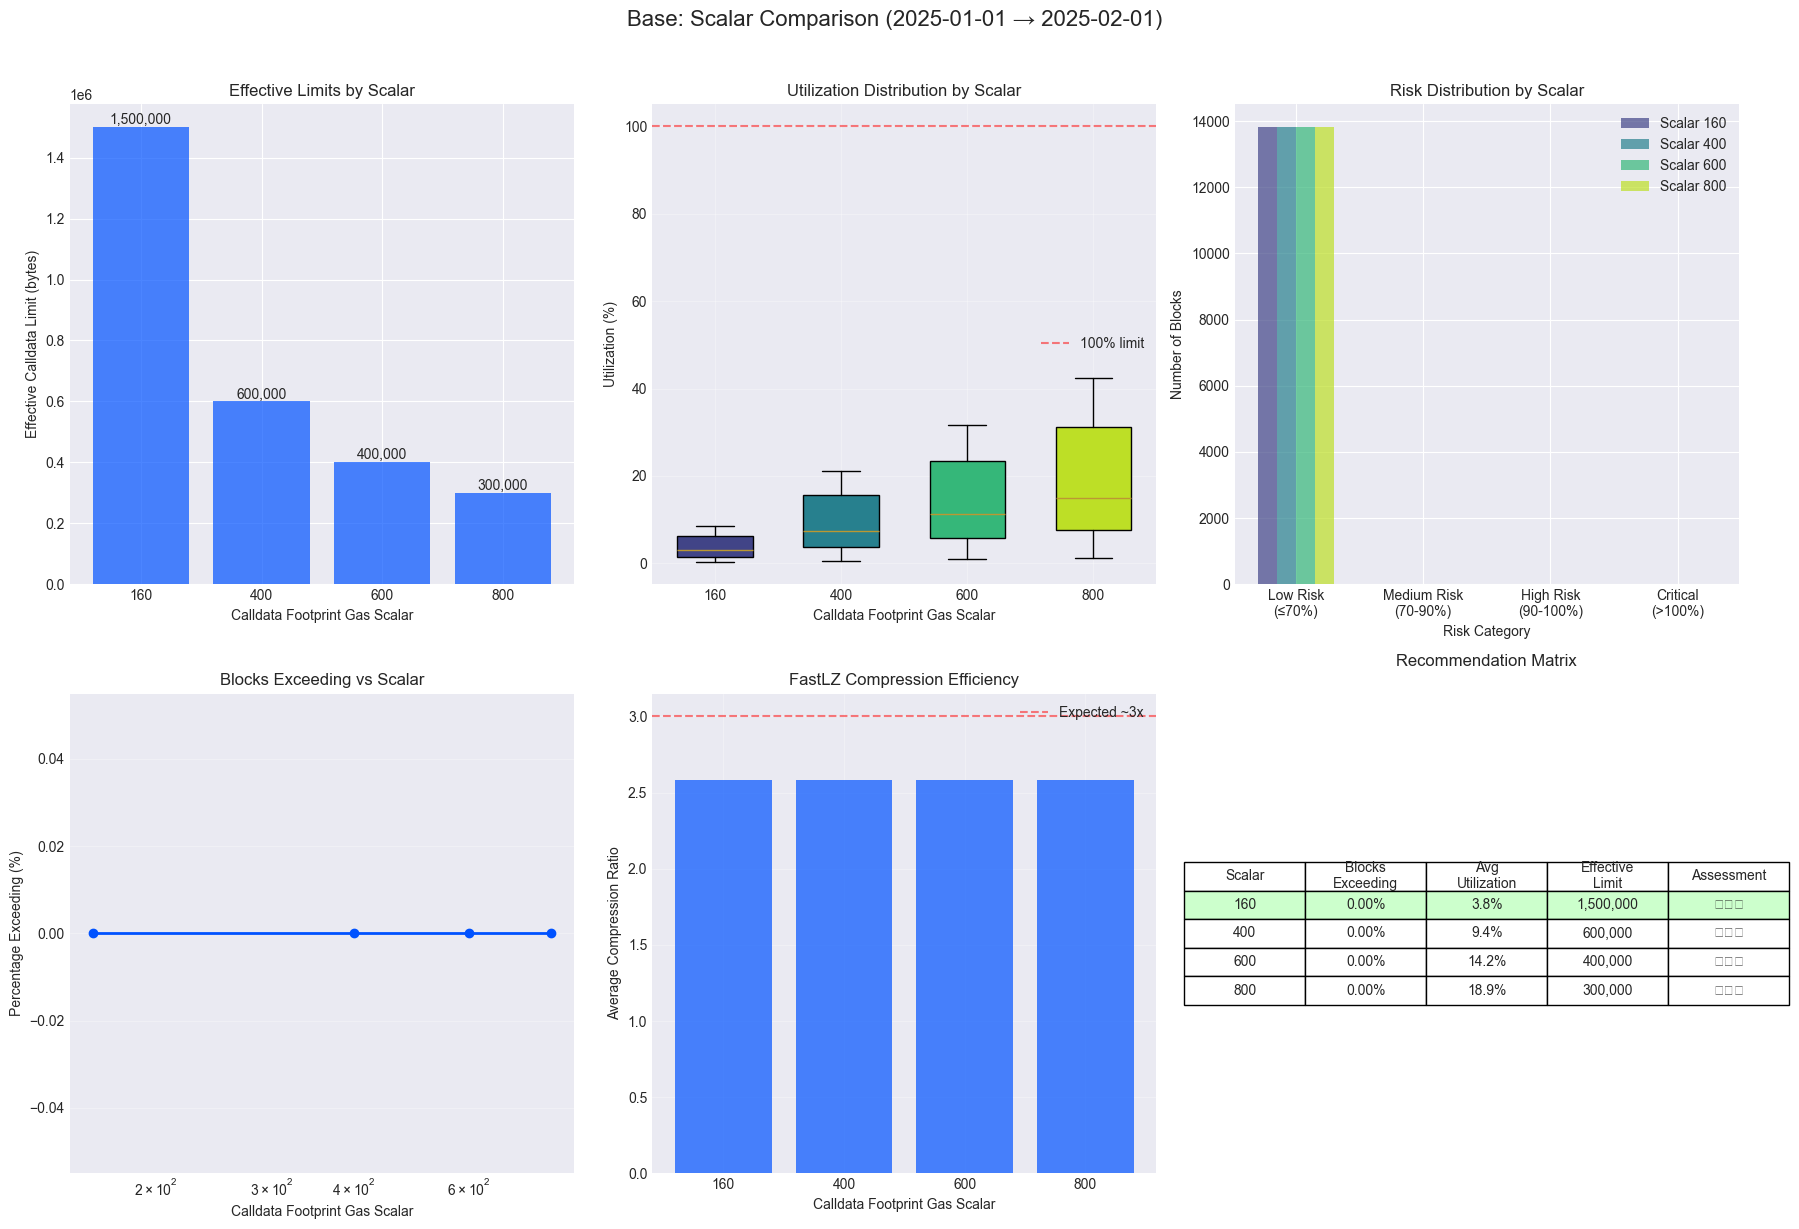

/Users/chuxinhuang/work/op-analytics/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


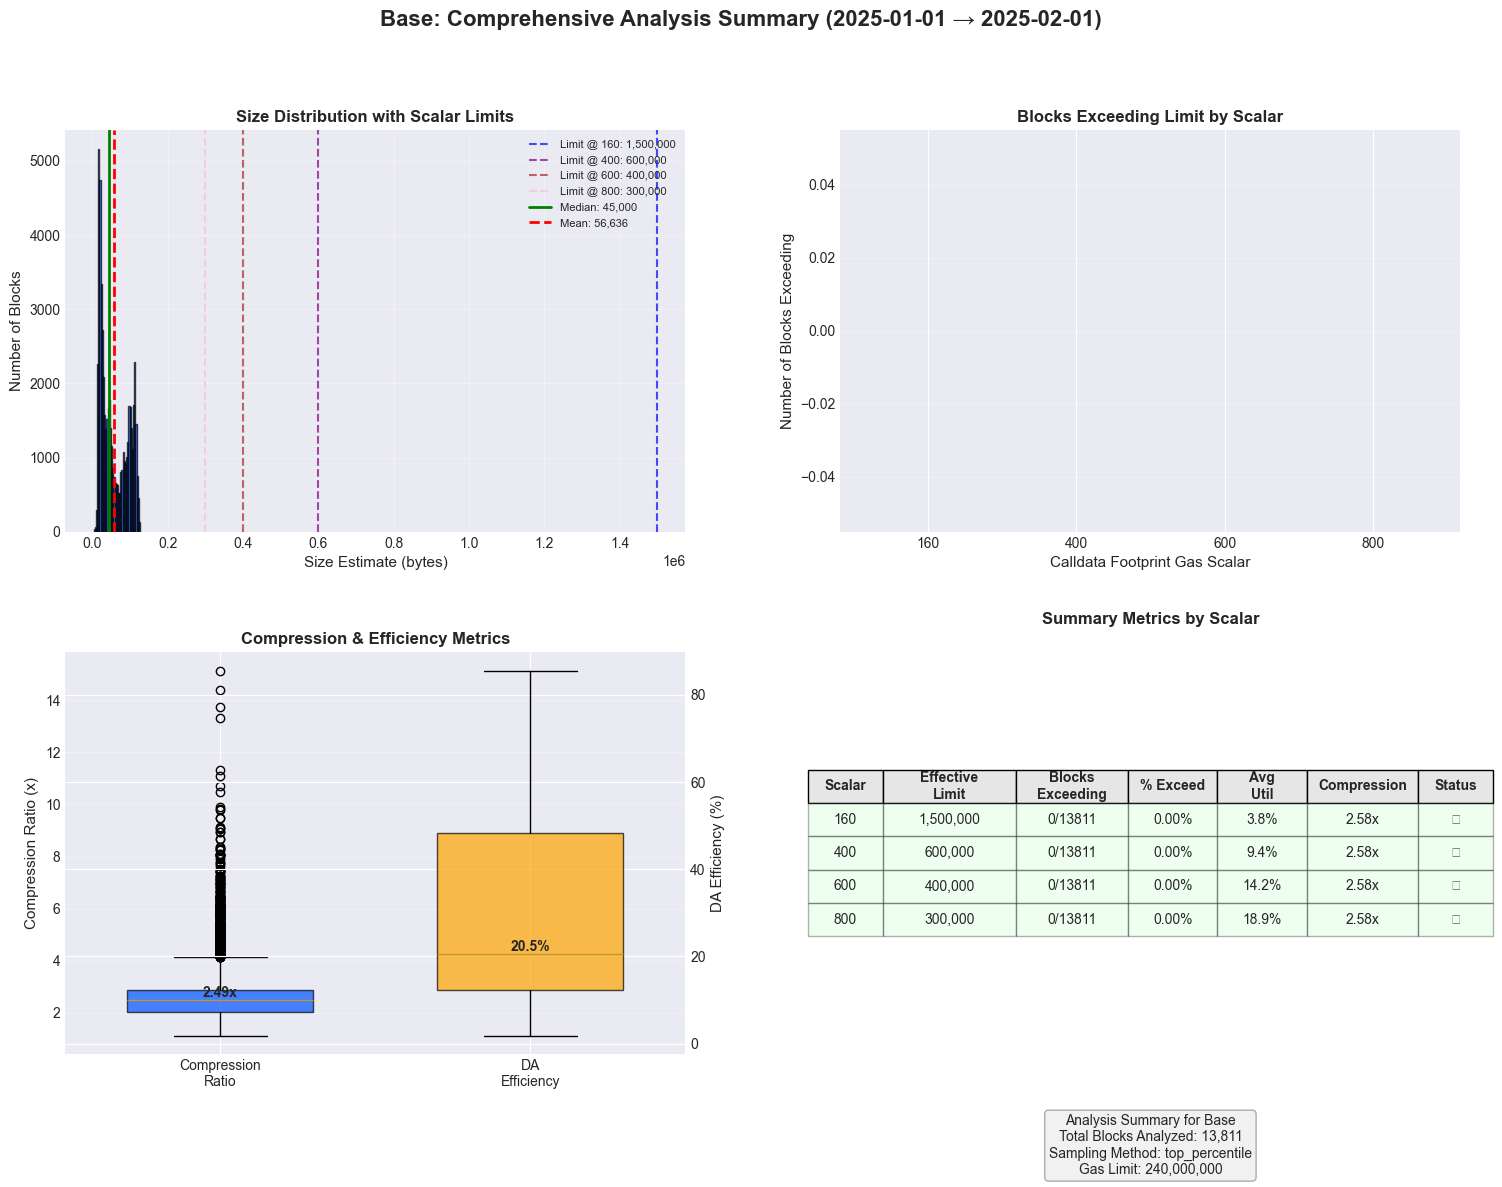

In [15]:
# Generate all Jovian visualizations with enhanced features
if analysis_results:
    print(f"📊 Generating enhanced visualizations for {get_chain_display_name(CHAIN)}...")
    
    # Generate all visualizations (includes new comprehensive summary)
    figures = generate_all_visualizations(
        results_by_scalar=analysis_results,
        output_dir=OUTPUT_DIR,
        chain=CHAIN,
        start_date=START_DATE,
        end_date=END_DATE
    )
    
    print(f"\n✅ Generated {len(figures)} visualizations:")
    print("   1. Size estimates histogram (with vertical lines & zones)")
    print("   2. Compression ratio histogram (with percentiles & zones)")
    print("   3. Blocks exceeding limits analysis")
    print("   4. Excess distribution")
    print("   5. Over-utilization percentages")
    print("   6. Scalar comparison")
    print("   7. Comprehensive summary (NEW)")
    print(f"\n📁 Saved to: {OUTPUT_DIR}")

## Step 8: Per-Date Analysis (for Date Ranges)

In [16]:
# Analyze each date separately
per_date_results = {}

if len(DATES_TO_ANALYZE) > 1 and fetch_summary:
    print(f"📊 PER-DATE ANALYSIS - {get_chain_display_name(CHAIN)}")
    print("=" * 60)
    
    for item in fetch_summary:
        date = item['date']
        df = item['df']
        gas_limit = item['gas_limit']
        
        print(f"\n📅 Analyzing {date} (gas limit: {gas_limit:,})")
        print(f"   Blocks: {df['block_number'].n_unique()}, Transactions: {len(df)}")
        
        # Analyze this date
        date_results = perform_jovian_analysis(
            df=df,
            gas_limit=gas_limit,
            calldata_footprint_gas_scalars=CALLDATA_FOOTPRINT_GAS_SCALARS,
            chain=CHAIN,
            sampling_method=SAMPLING_METHOD,
            start_date=START_DATE,
            end_date=END_DATE,
            show_progress=False
        )
        
        per_date_results[date] = date_results
        
        # Show summary for scalar 400
        if 400 in date_results:
            result = date_results[400]
            print(f"   Scalar 400: {result.blocks_exceeding}/{result.total_blocks} blocks exceed ({result.percentage_exceeding:.2f}%)")
            print(f"   Avg utilization: {result.avg_utilization:.2%}")
            if result.compression_metrics:
                print(f"   Compression ratio: {result.compression_metrics.get('avg_compression_ratio', 0):.2f}x")
    
    # Summary across dates
    if per_date_results:
        print(f"\n📊 SUMMARY ACROSS DATES (Scalar 400):")
        print("-" * 60)
        for date, results in per_date_results.items():
            if 400 in results:
                r = results[400]
                comp_ratio = r.compression_metrics.get('avg_compression_ratio', 0) if r.compression_metrics else 0
                print(f"{date}: {r.percentage_exceeding:6.2f}% exceed, {r.avg_utilization:6.2%} util, {comp_ratio:.2f}x compression")
else:
    print("\n📊 Single date analysis - skipping per-date breakdown")

📊 PER-DATE ANALYSIS - Base

📅 Analyzing 2025-01-01 (gas limit: 240,000,000)
   Blocks: 432, Transactions: 349941
   Scalar 400: 0/432 blocks exceed (0.00%)
   Avg utilization: 13.50%
   Compression ratio: 2.65x

📅 Analyzing 2025-01-02 (gas limit: 240,000,000)
   Blocks: 457, Transactions: 361140
   Scalar 400: 0/457 blocks exceed (0.00%)
   Avg utilization: 13.17%
   Compression ratio: 2.76x

📅 Analyzing 2025-01-03 (gas limit: 240,000,000)
   Blocks: 469, Transactions: 437344
   Scalar 400: 0/469 blocks exceed (0.00%)
   Avg utilization: 15.54%
   Compression ratio: 2.66x

📅 Analyzing 2025-01-04 (gas limit: 240,000,000)
   Blocks: 440, Transactions: 361398
   Scalar 400: 0/440 blocks exceed (0.00%)
   Avg utilization: 13.69%
   Compression ratio: 2.66x

📅 Analyzing 2025-01-05 (gas limit: 240,000,000)
   Blocks: 412, Transactions: 308743
   Scalar 400: 0/412 blocks exceed (0.00%)
   Avg utilization: 12.49%
   Compression ratio: 2.43x

📅 Analyzing 2025-01-06 (gas limit: 240,000,000)
   B

## Step 9: Trend Analysis (for Date Ranges)

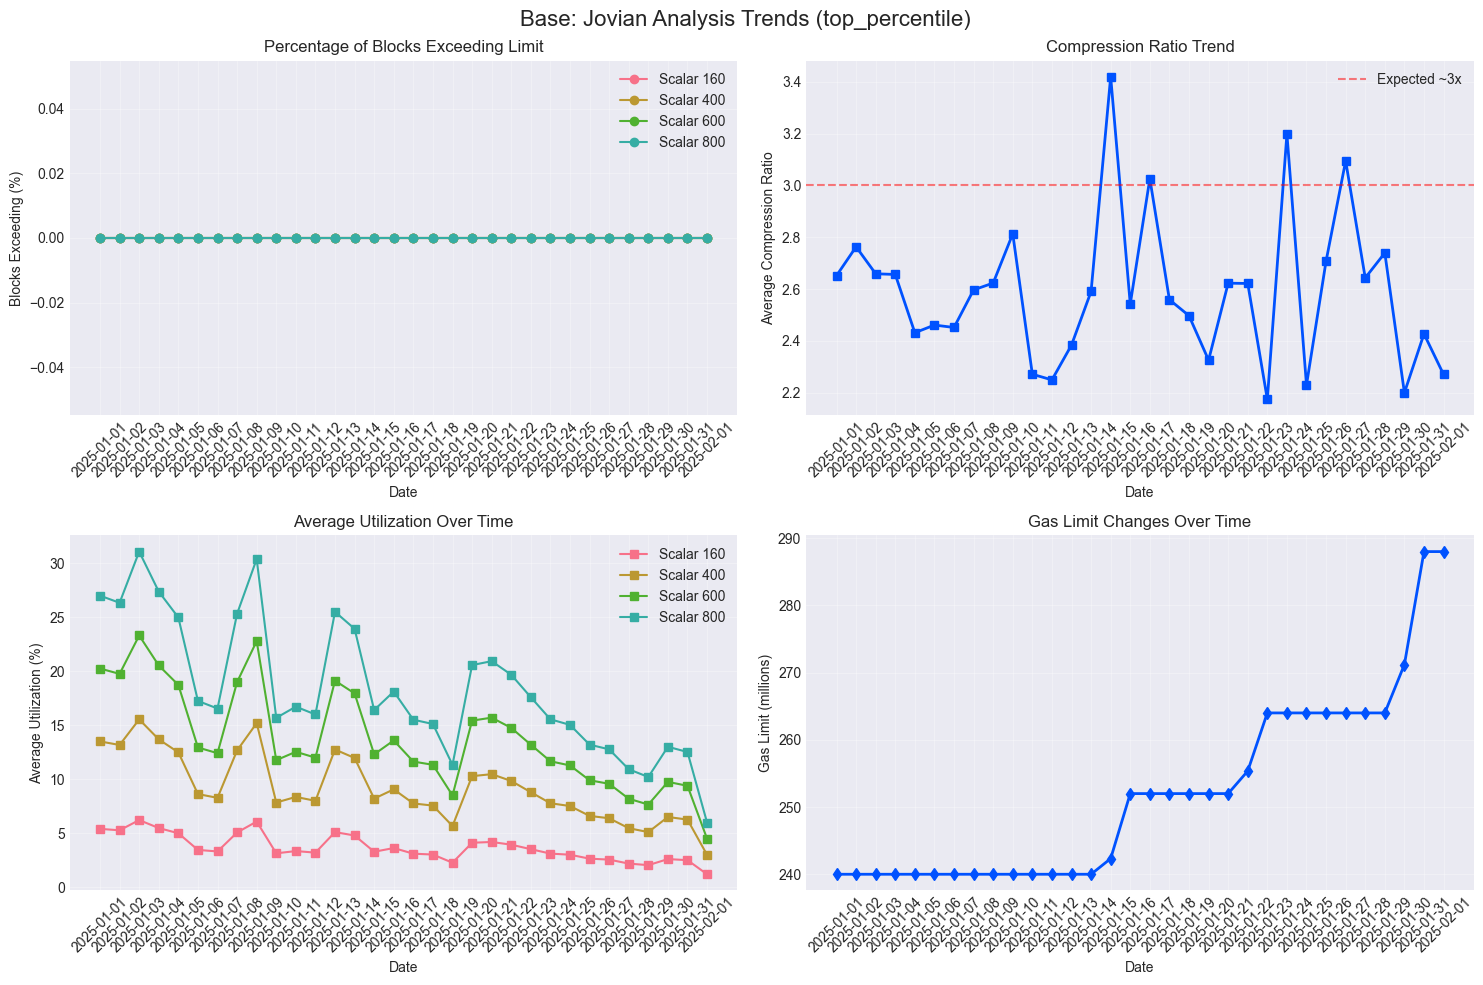

✅ Trend analysis saved to: ../results/base/visualizations_top_percentile_2025-01-01_2025-02-01/trend_analysis.png


In [17]:
# Plot trends across dates
if len(per_date_results) > 1:
    # Prepare data for plotting
    dates = sorted(per_date_results.keys())
    scalars_to_plot = [s for s in CALLDATA_FOOTPRINT_GAS_SCALARS if s in analysis_results]
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    chain_color = get_chain_color(CHAIN)
    fig.suptitle(f'{get_chain_display_name(CHAIN)}: Jovian Analysis Trends ({SAMPLING_METHOD})', fontsize=16)
    
    # Plot 1: Percentage exceeding over time
    ax = axes[0, 0]
    for scalar in scalars_to_plot:
        percentages = [per_date_results[d][scalar].percentage_exceeding 
                      for d in dates if scalar in per_date_results[d]]
        ax.plot(dates, percentages, marker='o', label=f'Scalar {scalar}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Blocks Exceeding (%)')
    ax.set_title('Percentage of Blocks Exceeding Limit')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    
    # Plot 2: Compression ratio over time
    ax = axes[0, 1]
    comp_ratios = []
    for d in dates:
        if 400 in per_date_results[d] and per_date_results[d][400].compression_metrics:
            comp_ratios.append(per_date_results[d][400].compression_metrics.get('avg_compression_ratio', 0))
        else:
            comp_ratios.append(0)
    
    ax.plot(dates, comp_ratios, marker='s', color=chain_color, linewidth=2)
    ax.axhline(y=3.0, color='red', linestyle='--', alpha=0.5, label='Expected ~3x')
    ax.set_xlabel('Date')
    ax.set_ylabel('Average Compression Ratio')
    ax.set_title('Compression Ratio Trend')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    
    # Plot 3: Average utilization over time
    ax = axes[1, 0]
    for scalar in scalars_to_plot:
        utilizations = [per_date_results[d][scalar].avg_utilization * 100 
                       for d in dates if scalar in per_date_results[d]]
        ax.plot(dates, utilizations, marker='s', label=f'Scalar {scalar}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Average Utilization (%)')
    ax.set_title('Average Utilization Over Time')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    
    # Plot 4: Gas limits over time
    ax = axes[1, 1]
    gas_limits_list = [date_gas_limits[d] / 1e6 for d in dates]  # Convert to millions
    ax.plot(dates, gas_limits_list, marker='d', color=chain_color, linewidth=2)
    ax.set_xlabel('Date')
    ax.set_ylabel('Gas Limit (millions)')
    ax.set_title('Gas Limit Changes Over Time')
    ax.grid(True, alpha=0.3)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Save the figure
    trend_file = OUTPUT_DIR / "trend_analysis.png"
    fig.savefig(trend_file, dpi=150, bbox_inches='tight')
    print(f"✅ Trend analysis saved to: {trend_file}")
else:
    print("\n📊 Single date or no per-date results - skipping trend analysis")

## Step 10: Verify Jovian Calculations

📊 DA efficiency (size_est / raw_calldata) — scalar 400
   n blocks: 13,811
   mean:   29.20%   median: 20.52%   p95: 61.39%
   overall avg in result.compression_metrics: 29.20%


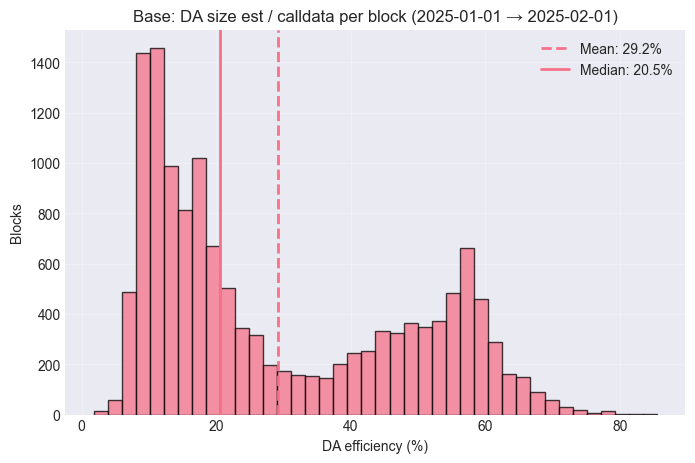

In [ ]:
scalar_to_peek = 400  
res = analysis_results[scalar_to_peek]
blocks = [b for b in res.block_analyses if b.total_calldata_size > 0]

bn   = np.array([b.block_number for b in blocks])
eff  = np.array([b.total_size_estimate / b.total_calldata_size for b in blocks])  # estimated compression ratio
mean_eff   = float(np.mean(eff))
median_eff = float(np.median(eff))
p95_eff    = float(np.percentile(eff, 95))
overall_avg_eff = res.compression_metrics.get("avg_da_efficiency", 0.0) 

print(f"📊 DA efficiency (size_est / raw_calldata) — scalar {scalar_to_peek}")
print(f"   n blocks: {len(eff):,}")
print(f"   mean:   {mean_eff:.2%}   median: {median_eff:.2%}   p95: {p95_eff:.2%}")
print(f"   overall avg in result.compression_metrics: {overall_avg_eff:.2%}")

plt.figure(figsize=(8,5))
plt.hist(eff * 100, bins=40, edgecolor='black', alpha=0.75)
plt.axvline(mean_eff * 100,   linestyle='--', linewidth=2, label=f"Mean: {mean_eff*100:.1f}%")
plt.axvline(median_eff * 100, linestyle='-',  linewidth=2, label=f"Median: {median_eff*100:.1f}%")
plt.axhline(0, color='k', lw=0.5)
range_str = f" ({START_DATE} → {END_DATE})" if START_DATE and END_DATE else ""
plt.title(f"{get_chain_display_name(CHAIN)}: DA size est / calldata per block{range_str}")
plt.xlabel("DA efficiency (%)"); plt.ylabel("Blocks"); plt.legend(); plt.grid(alpha=0.25)
plt.show()

## Summary

This **final** Jovian notebook provides:

### Features
✅ **Complete Analysis** - All functionality working correctly  
✅ **Per-Date Analysis** - Properly analyzes each date separately  
✅ **Enhanced Visualizations** - Vertical lines, zones, and comprehensive summary  
✅ **Optimized Queries** - Only fetch 5 essential columns (70% data reduction)  
✅ **Multi-chain Support** - Analyze any of the 7 supported chains  
✅ **Dual Sampling Methods** - Top percentile or random sampling  
✅ **Dynamic Gas Limits** - Per-chain historical CSV data  
✅ **Compression Analysis** - Ratio and DA efficiency metrics  
✅ **Trend Analysis** - For date ranges with 4-panel visualization  

### Key Improvements
- **Fixed Query Issues**: Removed correlated subqueries, optimized JOINs
- **Column Optimization**: Reduced from 16 to 5 columns (70% less data)
- **Enhanced Visualizations**: Added vertical lines, percentiles, and risk zones
- **Comprehensive Summary**: New single-page overview with all key metrics
- **Per-Date Analysis**: Properly tracks and analyzes each date separately

### How to Use

1. **Configure Parameters**:
   - Set `CHAIN` to target chain
   - Choose `SAMPLING_METHOD` and parameters
   - Set date range with `START_DATE` and `END_DATE`

2. **Run Analysis**:
   - Execute all cells in order
   - Review results and recommendations
   - Check visualizations in output directory

3. **Interpret Results**:
   - Use vertical lines to see where data falls relative to limits
   - Check risk zones for safety assessment
   - Review comprehensive summary for at-a-glance insights

The analysis provides clear, actionable insights for optimizing calldata footprint gas scalar selection.